In [1]:
from prevo.record import RecordBase, RecordingBase, SensorBase
from prevo.csv import RecordingToCsv
from prevo.misc import DummyPressureSensor, DummyTemperatureSensor
import pandas as pd
import oclock

# Define sensors

In [2]:
class Sensor(SensorBase):
    """Provide methods common to all sensors"""
    
    def  _read(self):
        # Automatically add time and time uncertainty in data dict
        with oclock.measure_time() as data:
            measurement = self.device.read()
            data['values'] = tuple(measurement.values())
        return data

In [3]:
class PressureSensor(Sensor):
    
    name = 'P'
    
    # This will be the names of columns in the CSV file
    # (as can be seen below, time columns are also added automatically)
    data_names = 'P1', 'P2', 'P3'
    
    # data_types is useful only when using live graphs
    data_types = 'P (Pa)', 'P (Pa)', 'P (mbar)'
    
    def __init__(self):
        self.device = DummyPressureSensor()


class TemperatureSensor(Sensor):
    
    name = 'T'
    data_names = 'T1', 'T2'
    data_types = 'T (°C)', 'T (°C)', 'P (mbar)'
    
    def __init__(self):
        self.device = DummyTemperatureSensor()

In [4]:
with PressureSensor() as sensor:
    data = sensor.read()
data

{'values': (3170.897578861687, 2338.380319679982, 17.282422994294976),
 'time (unix)': 1689172700.150032,
 'dt (s)': 2.291999408043921e-06}

In [5]:
Sensors = {Sensor.name: Sensor for Sensor in (PressureSensor, TemperatureSensor)}
Sensors

{'P': __main__.PressureSensor, 'T': __main__.TemperatureSensor}

# Define recordings

In [6]:
class Recording(RecordingToCsv, RecordingBase):
    """Recording class that defines how to read and handle data from sensors."""

    def __init__(self, name):
        
        Sensor = Sensors[name]
        column_names = ('time (unix)', 'dt (s)') + Sensor.data_names
        filename = 'Pressure.tsv' if name == 'P' else 'Temperature.tsv'

        RecordingBase.__init__(self, Sensor=Sensors[name], dt=2)
        RecordingToCsv.__init__(self, path='data', filename=filename, column_names=column_names)
        
recordings = {name: Recording(name) for name in ('P', 'T')}

COMMANDS {'dt': ControlledProperty (Δt (s)) [attribute: timer.interval] [commands: ('dt',)], 'on': ControlledProperty (Rec. ON) [attribute: active] [commands: ('on',)]}
COMMANDS {'dt': ControlledProperty (Δt (s)) [attribute: timer.interval] [commands: ('dt',)], 'on': ControlledProperty (Rec. ON) [attribute: active] [commands: ('on',)]}


# Start recording

In [15]:
class Record(RecordBase):
    """For simple cases no subclassing is necessary"""
    pass

**Note**: Below, by default recordings are OFF (`on=False`) option. After starting the recording, turn them on by typing `on True` in the CLI

In [16]:
record = Record(recordings, path='data', dt=3, dt_P=0.5, on=False)
record.start()

global {'dt': 3, 'on': False}
specific {'P': ('dt', 0.5)}
P <class 'clivo.cli.ControlledProperty'> Δt (s) (('dt',)) 3
T <class 'clivo.cli.ControlledProperty'> Δt (s) (('dt',)) 3
P <class 'clivo.cli.ControlledProperty'> Rec. ON (('on',)) False
T <class 'clivo.cli.ControlledProperty'> Rec. ON (('on',)) False
{'P': {<class 'clivo.cli.ControlledProperty'> Δt (s) (('dt',)): 0.5, <class 'clivo.cli.ControlledProperty'> Rec. ON (('on',)): False}, 'T': {<class 'clivo.cli.ControlledProperty'> Δt (s) (('dt',)): 3, <class 'clivo.cli.ControlledProperty'> Rec. ON (('on',)): False}}
Recording started in folder /Users/olivier.vincent/Python-OV/prevo/examples/data
Δt (s)
P---0.5
T---3
New Δt (s) for P: 5
Rec. ON
P---False
T---False
New Rec. ON for P: True
New Rec. ON for T: True
CLI stopped
Recording Stopped


In [17]:
pressure_data = pd.read_csv('data/Pressure.tsv', sep='\t')
pressure_data.head()

,time (unix),dt (s),P1,P2,P3
0,1.689170e+09,0.000008,3170.819832,2338.025854,17.466064
1,1.689170e+09,0.000004,3170.873416,2339.095267,17.132561


<Axes: xlabel='time (unix)'>

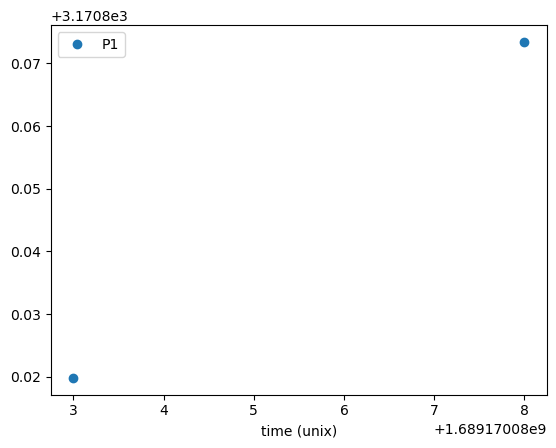

In [18]:
pressure_data.plot(x='time (unix)', y='P1', style='o')